In [1]:
import sys
sys.path.insert(0, '../../../flygenvectors/')

import os
import numpy as np
from glob import glob
import scipy.io as sio
from scipy import sparse, signal

from sklearn.decomposition import PCA, FastICA
# from skimage.restoration import denoise_tv_chambolle

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors

import matplotlib.pylab as pl
from scipy.stats import zscore
import data as dataUtils
import plotting
#import flygenvectors.ssmutils as utils

from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

### load data

In [2]:
main_dir = '/Volumes/dropboxdrive/Dropbox/00_AcademicFiles/12_ColumbiaDocumentsG6/00_AxelLab/01_Data/flygenvectors/datashare/SynologyDrive/_main/'
main_fig_dir = '/Volumes/dropboxdrive/Dropbox/00_AcademicFiles/12_ColumbiaDocumentsG6/00_AxelLab/01_Data/flygenvectors/figs/SynologyDrive/'
#main_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/dataShare/'
#main_fig_dir = '/Users/evan/Dropbox/_AxelLab/__flygenvectors/figures/'
# main_dir = '/Volumes/data1/_flygenvectors_dataShare/_main/_sparseLines/'
# main_fig_dir = '/Volumes/data1/figsAndMovies/figures/'

exp_date = '2019_10_14' 
fly_num = 'fly3'

data_dict = dataUtils.load_timeseries_simple(exp_date,fly_num,main_dir)
expt_id = exp_date+'_'+fly_num
fig_folder = main_fig_dir+expt_id+'/'+'figures/'
clustfig_folder = fig_folder+'clusters/'
if not os.path.exists(fig_folder):
    os.mkdir(main_fig_dir+expt_id)
    os.mkdir(fig_folder)
    os.mkdir(clustfig_folder)

# pre-processing

In [3]:
# normalize dFF by noise variance (not currently used below)
dFFn = data_dict['dFF'].copy()
sn = np.zeros(dFFn.shape[0])
for i in range(dFFn.shape[0]):
    sn[i] = dataUtils.estimate_noise_variance(dFFn[i,:])
    dFFn[i,:] = dFFn[i,:]/sn[i]
data_dict['dFFn'] = dFFn

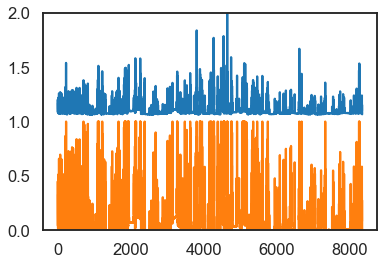

In [4]:
# preprocess behavior
# (goal is to squish upper range so single points don't dominate, 
# and truncate lower range so baseline is approximately zero throughout)
behavior = np.squeeze(data_dict['ball']).copy()

plt.figure()
plt.plot(1+behavior/behavior.max())
behavior = plotting.trim_dynamic_range(behavior, 0.4, 0.99)

plt.plot(behavior)
plt.ylim((0,2))
plt.show()

data_dict['ball'] = behavior

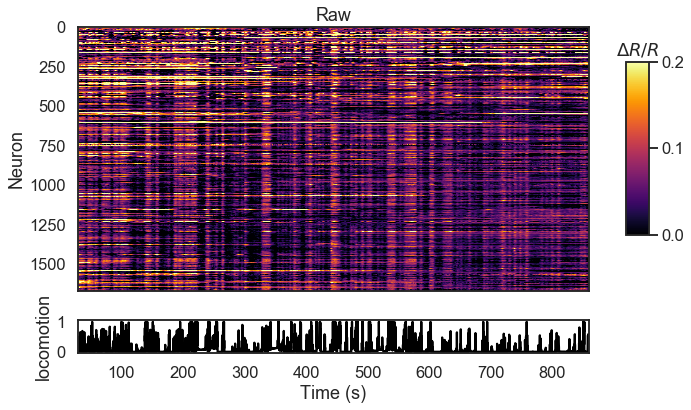

In [5]:
# visualize raw data
# Note: optional second arg of show_raster_with_behav is color range,
# accepts (min,max) tuple, defaults to (0,0.4), also accepts 'auto'

dt = data_dict['time'][1]-data_dict['time'][0]
tPl = data_dict['time'][0]+np.linspace(0,dt*len(data_dict['time']),len(data_dict['time']))
data_dict['tPl'] = tPl
plotting.show_raster_with_behav(data_dict,(0,0.2))
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_raster.pdf',transparent=True, bbox_inches='tight')

# Analysis of time constants relating dFF to behavior

In [6]:
# find optimal time constant PER NEURON with which to filter ball trace to maximize correlation
tauList, corrMat = dataUtils.estimate_neuron_behav_tau(data_dict)

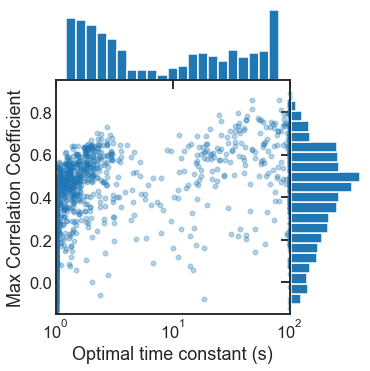

In [7]:
plotting.show_tau_scatter(tauList, corrMat, data_dict)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_tauScatter.pdf',transparent=True, bbox_inches='tight')
plt.show()

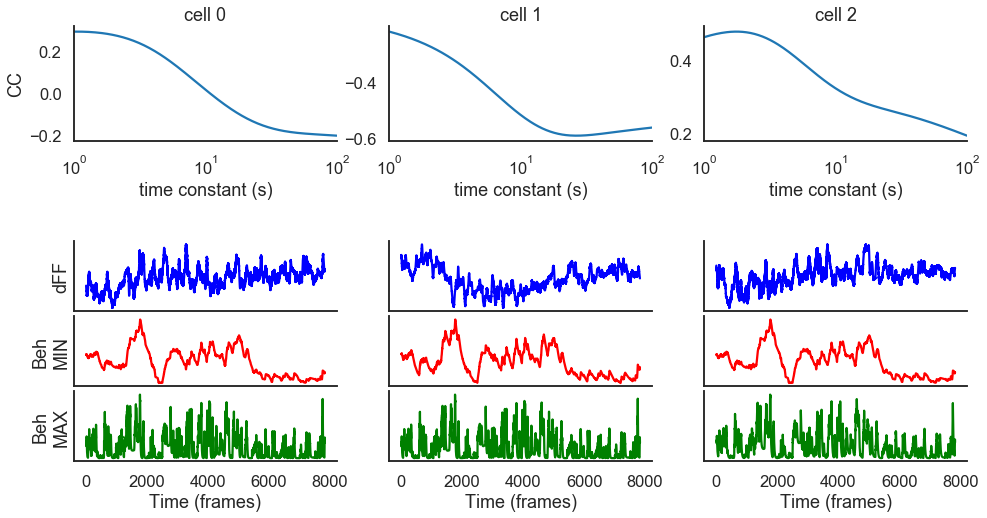

In [8]:
# show example cells
cell_ids = [232,250,253]
plotting.show_example_cells_bestTau(cell_ids, corrMat, tauList, data_dict)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_tauSamples.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [9]:
# make brain volume with cells color coded by tau
clrs = len(tauList)
tau_argmax = np.argmax(corrMat,axis=1)
R, mask_vol = plotting.make_colorCoded_cellMap(tau_argmax, clrs, data_dict)

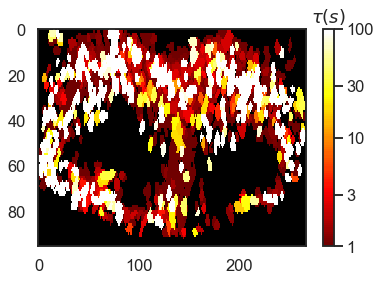

In [10]:
# make COLORBAR for 'brain volume with cells color coded by tau
fullList=tauList/data_dict['scanRate']
tau_label_list=[1,3,10,30,100]
tau_loc_list = plotting.make_labels_for_colorbar(tau_label_list, fullList)
plotting.make_colorBar_for_colorCoded_cellMap(R, mask_vol, tauList, tau_label_list, tau_loc_list, data_dict)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_tauMap_colorbar.pdf',transparent=True, bbox_inches='tight')
plt.show()

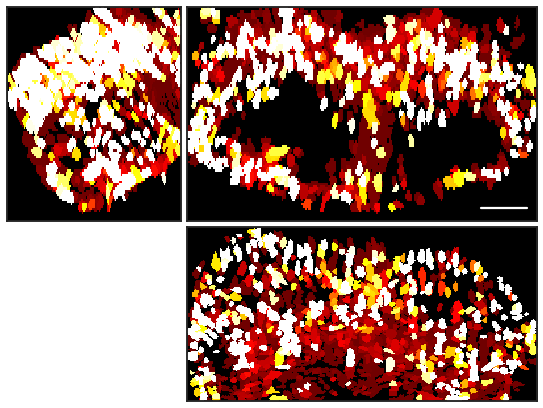

In [11]:
# show brain volume with cells color coded by tau
# in correct spatial dims (bar=50um), color matches above (in secs)
plotting.show_colorCoded_cellMap(R, mask_vol, tau_loc_list[[0,-1]], data_dict)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_tauMap.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [12]:
# show location of 'slow' cells, color coded by CC
cbounds = (-1, 1) # corr from -1 to 1
tau_valmax = np.max(corrMat,axis=1) # color by max cc instead of argmax as above
S, mask_vol = plotting.make_colorCoded_cellMap(tau_valmax, clrs, data_dict, cbounds)

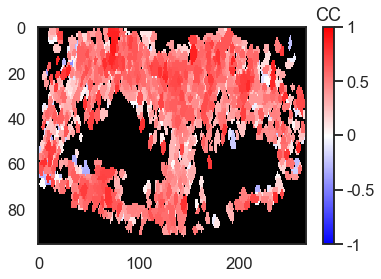

In [13]:
# make COLORBAR for 'brain volume with cells color coded by CC
cmap = 'bwr'
ccList=np.linspace(-1.0, 1.0, num=len(tauList))
label_list=[-1,-0.5,0,0.5,1]
cc_loc_list = plotting.make_labels_for_colorbar(label_list, ccList)
plotting.make_colorBar_for_colorCoded_cellMap(S, mask_vol, ccList, label_list, cc_loc_list, data_dict, cmap)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_ccMap_colorbar.pdf',transparent=True, bbox_inches='tight')
plt.show()

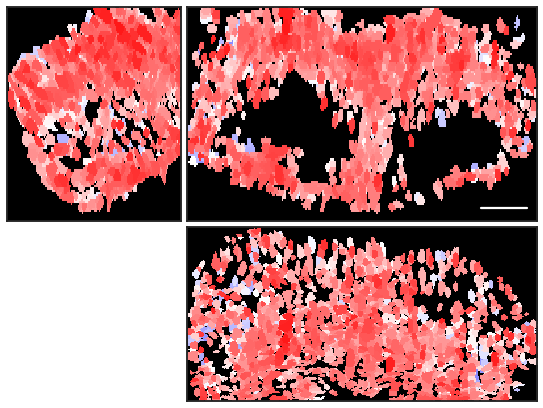

In [14]:
# show brain volume with cells color coded by max CC
# in correct spatial dims (bar=50um), color from CC=-1 to CC=1
plotting.show_colorCoded_cellMap(S, mask_vol, tau_loc_list[[0,-1]], data_dict, cmap)
plt.savefig(fig_folder + exp_date + '_' + fly_num +'_ccMap.pdf',transparent=True, bbox_inches='tight')
plt.show()